In [33]:
import numpy as np
import os
from matplotlib import pyplot as plt

template_path = './arch'
test_path = './datasets/nodemcu-random-test2'

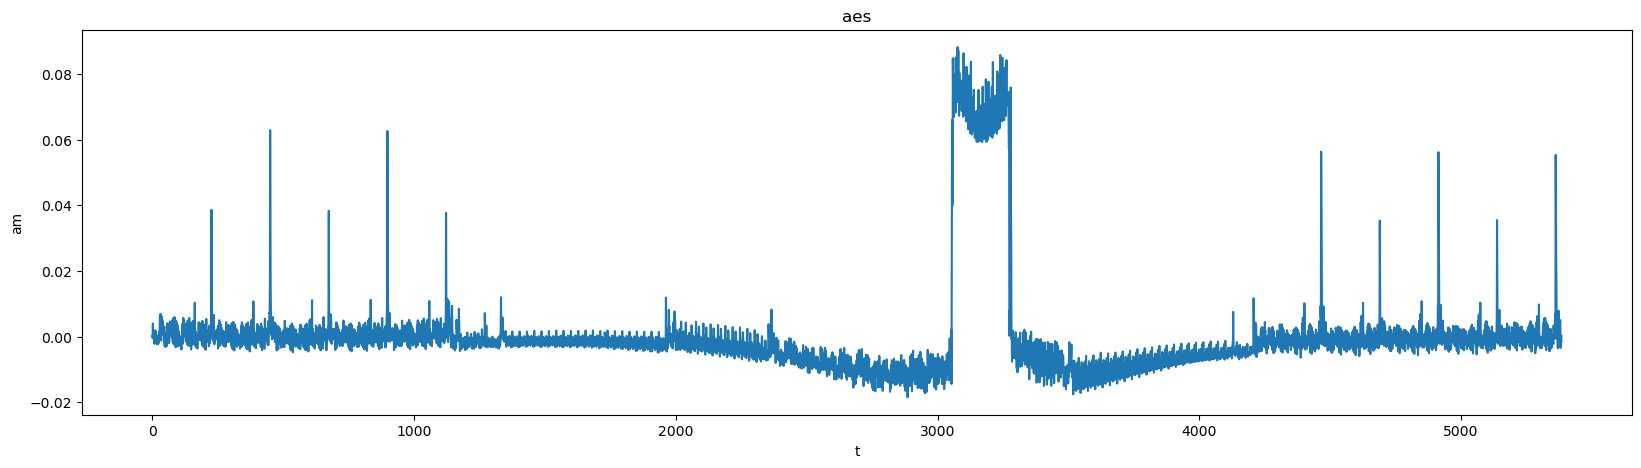

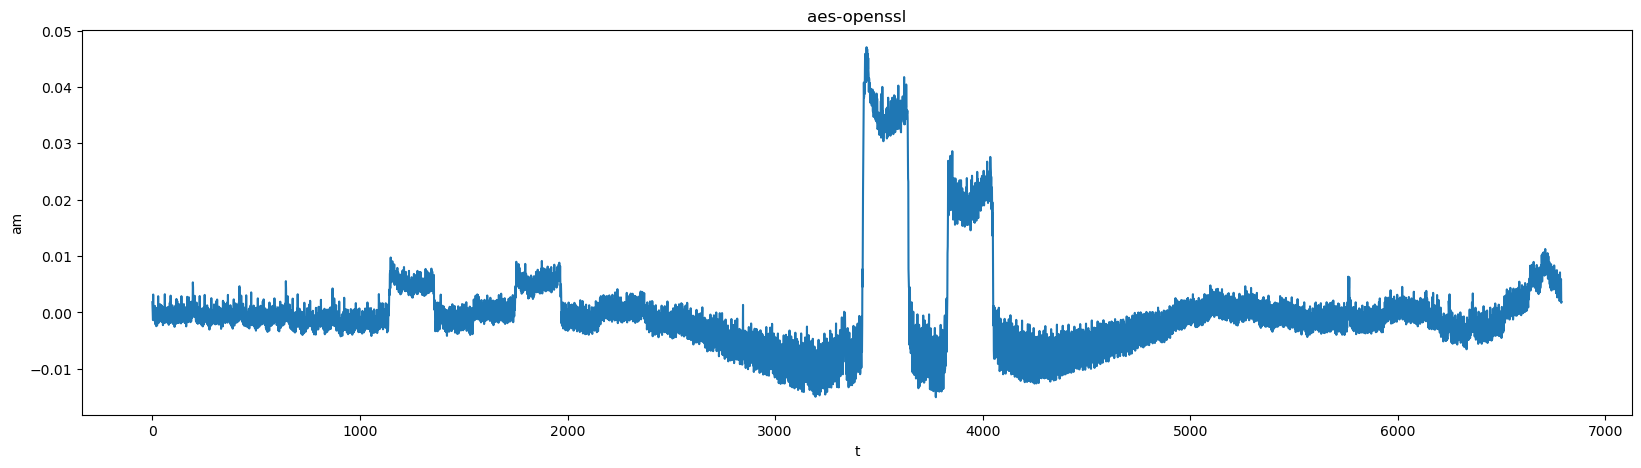

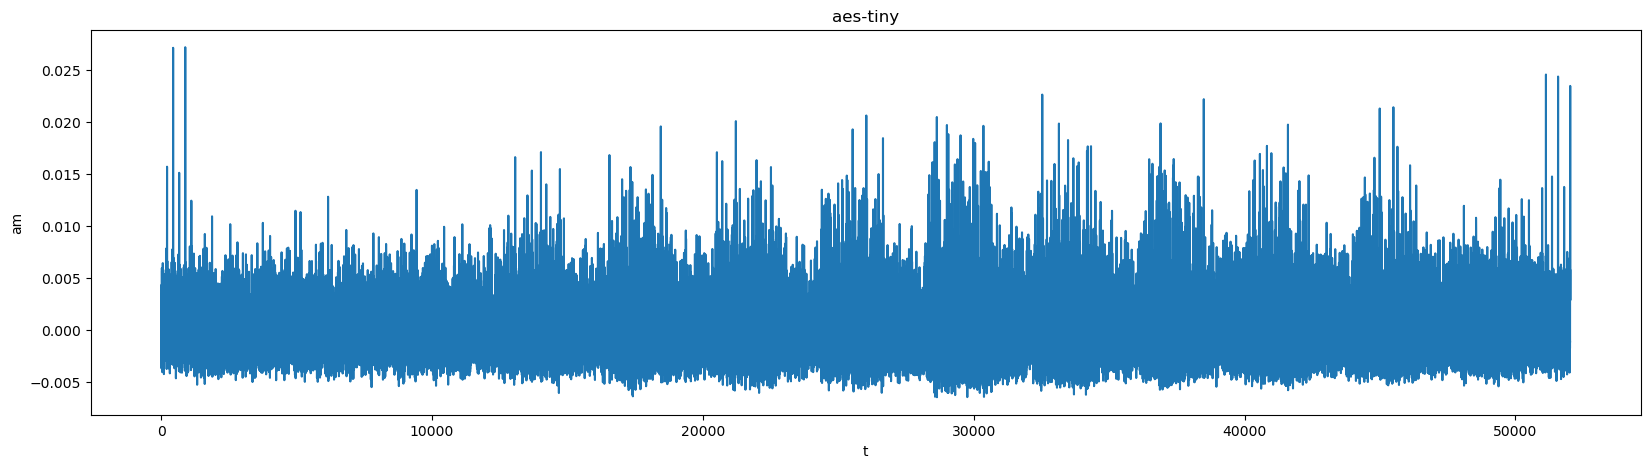

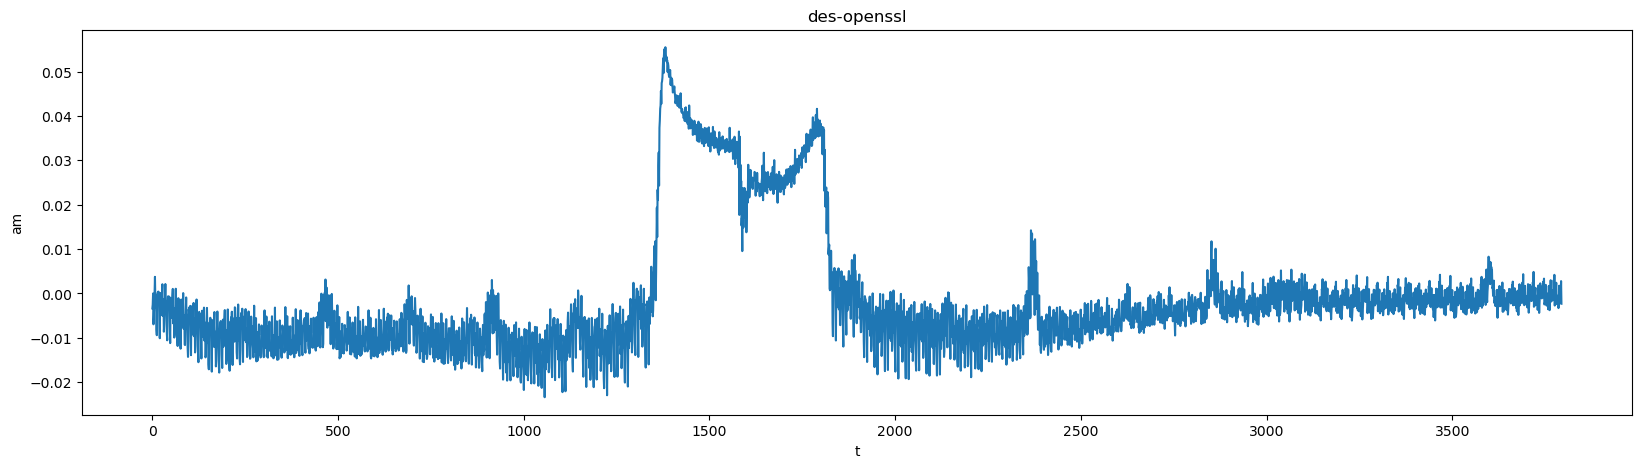

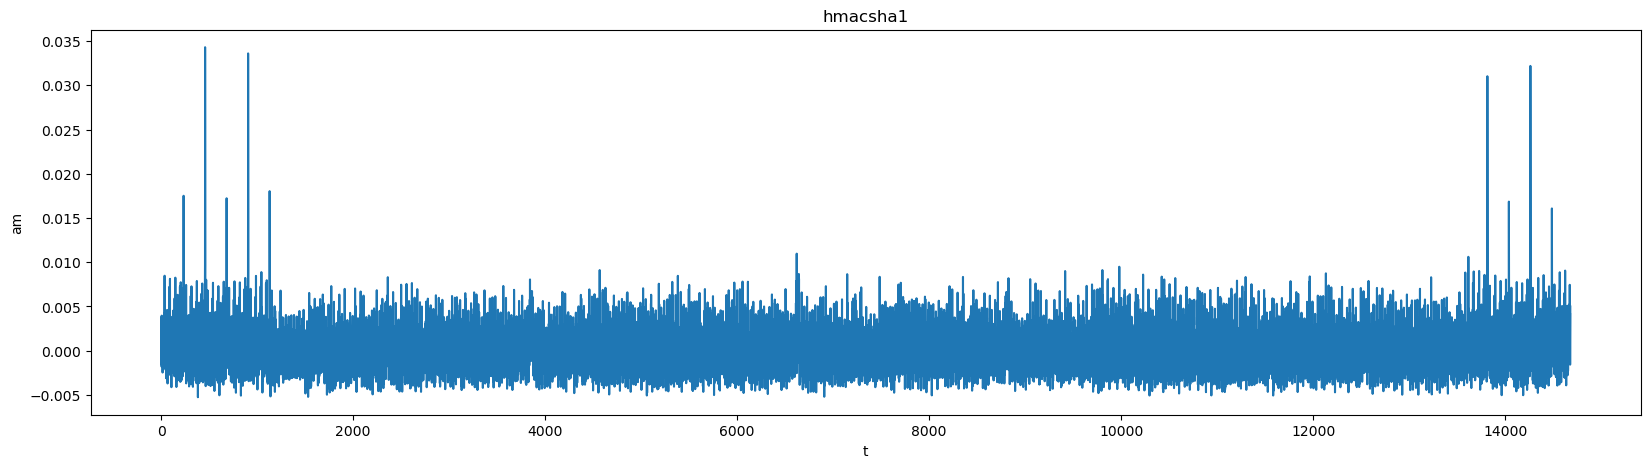

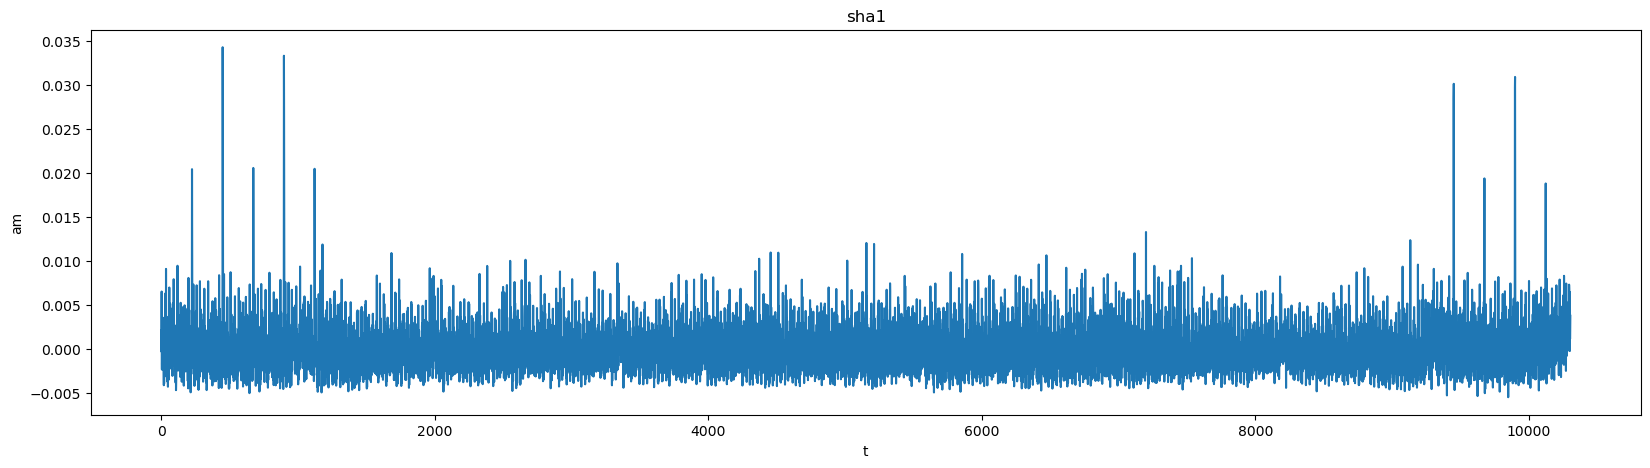

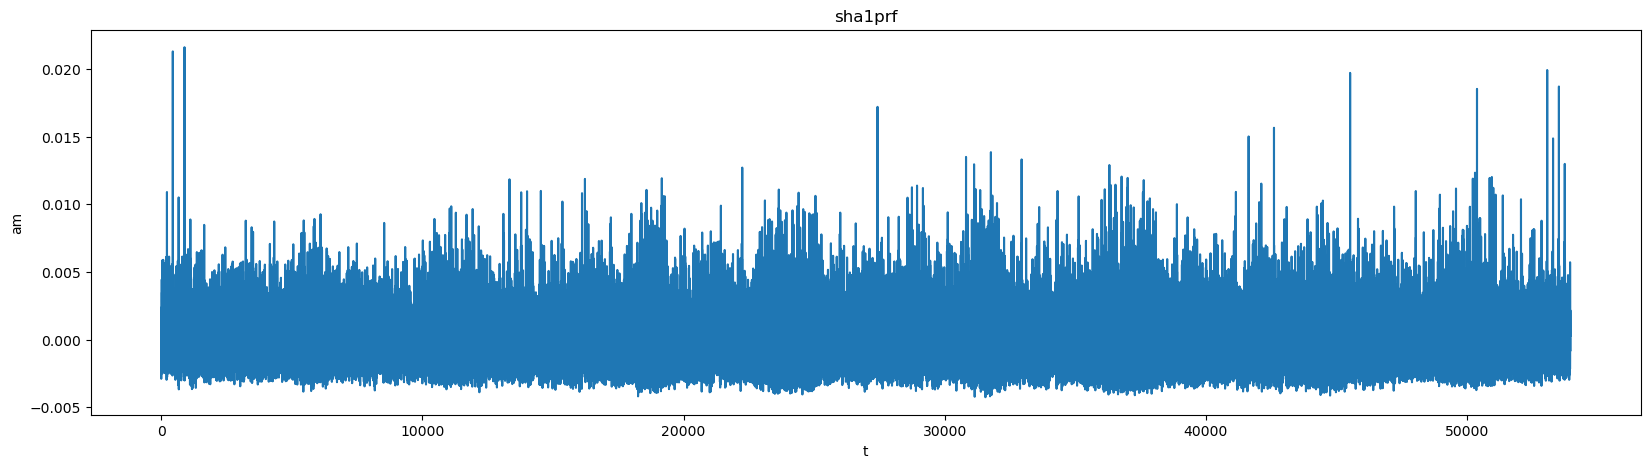

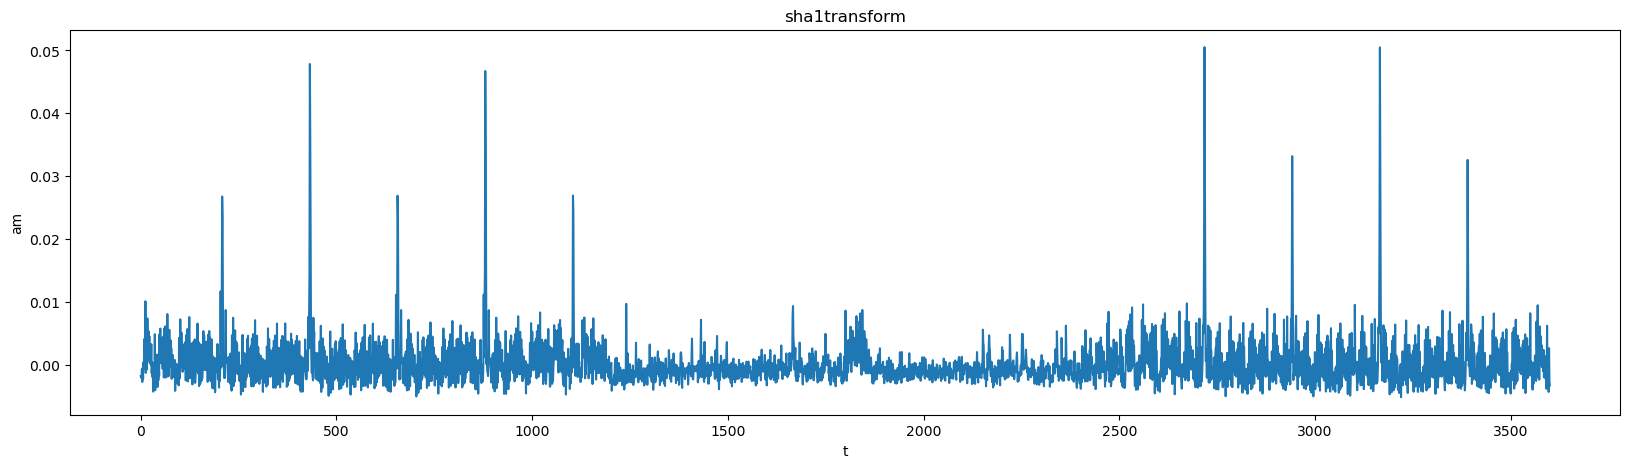

In [31]:
# Load and plot templates
filelist = os.listdir(template_path)
for file in filelist:  
    filepath = os.path.join(template_path, file)
    template = np.load(filepath, allow_pickle=True)

    if len(file.split('-'))== 3:
        op = file.split('-')[1]
    else:
        op = '-'.join(file.split('-')[1:3])
    
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(np.linspace(0, len(template), len(template)), template)
    ax.set(xlabel='t')
    ax.set_ylabel('am')
    ax.set_title(op)
    plt.show() 

# *Zero-mean normalized cross-correlation*

operation $o$
$$\hat{o}=\mathop{\arg \max }_{o\in O} {(\max_t {(c_{b_o,x}(t))})}$$


In [43]:
dataset_files = os.listdir(test_path)
print(dataset_files)
for i, file in enumerate(dataset_files):
    if '_traces.npy' in file:
        trace_name = file
        meta_name = file.rpartition('_traces.npy')[0] + "_meta.p"
        # print(trace_name, meta_name)
    
        trace_path = os.path.join(test_path, trace_name)
        meta_path = os.path.join(test_path, meta_name)
        meta = np.load(meta_path, allow_pickle=True)
        
        # Meta = 16 dicts, 
        

['2020-02-17_11-14-05_952049_knownkey.npy', '2020-02-17_11-14-05_952049_meta.p', '2020-02-17_11-14-05_952049_textin.npy', '2020-02-17_11-14-05_952049_traces.npy', '2020-02-17_11-14-06_367108_knownkey.npy', '2020-02-17_11-14-06_367108_meta.p', '2020-02-17_11-14-06_367108_textin.npy', '2020-02-17_11-14-06_367108_traces.npy', '2020-02-17_11-14-06_760726_knownkey.npy', '2020-02-17_11-14-06_760726_meta.p', '2020-02-17_11-14-06_760726_textin.npy', '2020-02-17_11-14-06_760726_traces.npy', '2020-02-17_11-14-07_138974_knownkey.npy', '2020-02-17_11-14-07_138974_meta.p', '2020-02-17_11-14-07_138974_textin.npy', '2020-02-17_11-14-07_138974_traces.npy', '2020-02-17_11-14-07_539135_knownkey.npy', '2020-02-17_11-14-07_539135_meta.p', '2020-02-17_11-14-07_539135_textin.npy', '2020-02-17_11-14-07_539135_traces.npy', '2020-02-17_11-14-07_932116_knownkey.npy', '2020-02-17_11-14-07_932116_meta.p', '2020-02-17_11-14-07_932116_textin.npy', '2020-02-17_11-14-07_932116_traces.npy', '2020-02-17_11-14-08_330190